In [1]:
import numpy as np
import pandas as pd
from IPython.display import display, Image
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### FM，对特征进行组合
　　FM（Factorization Machine），用于解决稀疏数据下的特征组合问题，常用于广告的CTR预估。工业界用的较多的是基于LR（logistic回归）的点击预估策略，使用GBDT+FM用树和FM来做高阶特征生成，最后在使用sigmoid（套用logistic回归，将其映射为概率），能增强LR的非线性能力。与DNN（深度神经网络）用线性组合+非线性函数来做高阶特征生成相比，二者效果相差不大。

　　某些特征经过关联之后，与label之间的相关性就会提高。例如，“USA”与“Thanksgiving”、“China”与“Chinese New Year”这样的关联特征，对用户的点击有着正向的影响。换句话说，来自“China”的用户很可能会在“Chinese New Year”有大量的浏览、购买行为，而在“Thanksgiving”却不会有特别的消费行为。这种关联特征与label的正向相关性在实际问题中是普遍存在的，如“化妆品”类商品与“女”性，“球类运动配件”的商品与“男”性，“电影票”的商品与“电影”品类偏好等。因此，引入两个特征的组合是非常有意义的。

### 使用one-hot编码的问题
　　下面以一个示例引入FM模型。假设一个广告分类的问题，根据用户和广告位相关的特征，预测用户是否点击了广告。源数据如下：

In [3]:
ad_df = pd.DataFrame(columns=['Clicked', 'Country', 'Day', 'Ad_type'])
ad_df['Clicked'] = [1, 0, 1]
ad_df['Country'] = ['USA', 'China', 'China']
ad_df['Day'] = ['26/11/15', '1/7/14', '19/2/15']
ad_df['Ad_type'] = ['Movie', 'Game', 'Game']

In [4]:
ad_df

,Clicked,Country,Day,Ad_type
0,1,USA,26/11/15,Movie
1,0,China,1/7/14,Game
2,1,China,19/2/15,Game


　　"Clicked"是label，Country、Day、Ad_type是特征。由于三种特征都是categorical类型的，经过独热编码（One-Hot Encoding）转换成数值型特征。

In [5]:
pd.get_dummies(ad_df)

,Clicked,Country_China,Country_USA,Day_1/7/14,Day_19/2/15,Day_26/11/15,Ad_type_Game,Ad_type_Movie
0,1,0,1,0,0,1,0,1
1,0,1,0,1,0,0,1,0
2,1,1,0,0,1,0,1,0


　　由上表可以看出，经过One-Hot编码之后，大部分样本数据特征是比较稀疏的。上面的样例中，每个样本有7维特征，但平均仅有3维特征具有非零值。实际上，在真实应用场景中这种情况普遍存在。例如，CTR/CVR预测时，用户的性别、职业、教育水平、品类偏好，商品的品类等，经过One-Hot编码转换后都会导致样本数据的稀疏性。特别是电商，如商品品类这种类型的特征，如商品的末级品类约有550个，采用One-Hot编码生成550个数值特征，但每个样本的这550个特征，有且仅有一个是有效的（非零）。由此可见，数据稀疏性是实际问题中不可避免的挑战。<br >
　　One-Hot编码的另一个特点就是导致特征空间大。例如，淘宝上的商品有上百万，使用one-hot编码后，一个物品ID项可扩展上百万的维度，由此特征空间剧增带来的数据的稀疏性。

### FM公式推导
　　这里以二阶多项式模型为例，因其包含组合特征$x_{i} x_{j}$，公式如下：
$$y(x) = w_{0} + \sum _{i=1}^{n} w_{i}x_{i} + \sum _{i=1}^{n} \sum _{j=i+1}^{n} w_{ij} x_{i}x_{j}$$

　　其中，n代表样本的特征数量，$x_{i}$是第i个特征，$w_{0}$、$w_{i}$、$w_{ij}$是模型参数。从上式可看出，组合特征的参数$w_{ij}$一共有$\frac {n(n-1)}{2}$个，并且任意两个参数是独立的，如$x_{h}x_{i}$的系数$w_{hi}$和$x_{i}x_{j}$的系数$w_{ij}$是相互独立的，即使拥有共同项$x_{i}$。这样就存在一些问题，即前面提到的，使用one-hot编码带来的特征空间增大，导致数据的稀疏性。而在数据稀疏的情况下，二次项参数的训练是很难的。<br >
　　举例，假设我们要估计小A和星际迷航ST电影间的关系（评分）。显然，训练集不存在两个变量 $x_{A}$和 $x_{ST}$都不为0的情况。因此直接估计则为 $W_{A, ST}=0$，但可以通过分解参数 $<V_{A}, V_{ST}>$ 来估计。首先，小B和小C有相似的因素向量 $v_{B}$和$v_{C}$，因为都对电影星球大战$(v_{SW})$有相似的预测分数，即 $<v_{B}, v_{SW}>$ 和 $<v_{C}, v_{SW}>$ 这两向量相似，小A $(v_{A})$ 和 小C $(v_{C})$ 有不同的因素向量，因为小A对泰坦尼克号和星球大战有预测分数。接下来，星际迷航的因素向量与星球大战类似，因为小B对其有相同的预测分数。这意味着，小A和星际迷航的内积可近似为小A和星球大战的内积。<br >
　　所以将 $w_{ij}$分解为两个矩阵的点积 $<v_{i}, v_{j}>$，即：

$$\sum _{i=1}^{n} \sum _{j=i+1}^{n} w_{ij} x_{i}x_{j}\\
=\sum _{i=1}^{n} \sum _{j=i+1}^{n} < v_{i}, v_{j}> x_{i}x_{j}\\
= \frac{1}{2} \sum _{i=1}^{n} \sum _{j=1}^{n} < v_{i}, v_{j}> x_{i}x_{j} - \frac{1}{2} \sum _{i=1}^{n} < v_{i}, v_{i}> x_{i}x_{i}\\
=\frac{1}{2} (\sum _{i=1}^{n} \sum _{j=1}^{n} \sum _{k=1}^{K} v_{ik} v_{jk} x_{i}x_{j} - \sum _{i=1}^{n} \sum _{k=1}^{K}v_{ik}v_{ik}  x_{i}x_{i})\\
=\frac {1}{2} \sum _{k=1}^{K} ((\sum _{i=1}^{n} v_{ik} x_{i})(\sum _{j=1}^{n} v_{jk} x_{j}) - \sum _{i=1}^{n} v_{ik}^{2} x_{i}^{2})\\
=\frac{1}{2} \sum _{k=1}^{K} ((\sum _{i=1}^{n} v_{ik} x_{i})^{2} - \sum _{i=1}^{n} v_{ik}^{2} x_{i}^{2})$$

　　记$\sum _{i=1}^{n-1} \sum _{j=i+1}^{n} < v_{i}, v_{j}> x_{i}x_{j}$作为S，在矩阵中显示如下红色值或蓝色值，则整个矩阵可以表示为上三角（红色值）+下三角（蓝色值）+对角线（绿色值）：
$$2S + \sum _{i=1}^{n} <v_{i}, v_{i}> x_{i}x_{i} = \sum _{i=1}^{n} \sum _{j=1}^{n} <v_{i}, v_{j}> x_{i} x_{j}\\
S=\frac {1}{2} (\sum _{i=1}^{n} \sum _{j=1}^{n} <v_{i}, v_{j}> x_{i} x_{j} - \sum _{i=1}^{n} <v_{i}, v_{i}> x_{i}x_{i})$$
　　即上式中第一步的计算过程。

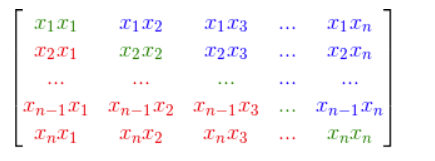

In [2]:
Image('https://raw.githubusercontent.com/martin-1992/Recommended-system/master/\
factorization_machines/factorization_machines01.png')

　　接着对其进行求导，使用梯度下降训练更新参数：
$$y(x) = w_{0} + \sum _{i=1}^{n} w_{i}x_{i} + \sum _{i=1}^{n} \sum _{j=i+1}^{n} w_{ij} x_{i}x_{j}\\
= w_{0} + \sum _{i=1}^{n} w_{i}x_{i} + \sum _{i=1}^{n} \sum _{j=i+1}^{n} <v_{i}, v_{j}> x_{i}x_{j}\\
=\frac {\partial y(x)}{\partial \Theta } = \begin{cases}
1 & \text{ if } \Theta = w_{0}\\ 
x_{i} & \text{ if } \Theta = w_{i}\\ 
x_{i} \sum _{j=1}^{n} v_{jk}x_{j} - v_{ik}x_{i}^{2} & \text{ if } \Theta = v_{ik}
\end{cases}$$

　　其中，$v_{i}$是第 $i$ 维特征隐向量，$<v_{i}, v_{j}>$ 表示向量点点积，即使用矩阵分解方法，将权重矩阵分解为两个矩阵相乘 $w_{ij} = v_{i} \cdot v_{j}$，假设 $w_{ij}$的大小为 $V * N$，则 $v_{i}$的大小为 $V * K$，$ v_{j} $的大小为 $K* N$，$V * N = (V * K)  \cdot (K* N)$，这里 $K$ 表示隐向量的长度，包含 $K$ 个描述特征的因子。<br >
　　根据上式，二次项的参数数量减少为 $kn$ 个，远少于多项式模型的参数数量。另外，参数因子化使得 $ x_{h}x_{i} $ 的参数和 $x_{i} x_{j}$ 的参数不再是相互独立的，因此我们可以在样本稀疏的情况下相对合理地估计FM的二次项参数。具体来说， $ x_{h}x_{i} $ 和 $x_{i} x_{j}$ 的系数分别为 $⟨v_{h},v_{i}⟩ $和 $⟨v_{i}, v_{j}⟩$，它们之间有共同项 $v_{i}$。也就是说，所有包含“$v_{i}$ 的非零组合特征”（存在某个 j≠i，使得 xixj≠0）的样本都可以用来学习隐向量 $v_{i}$，这很大程度上避免了数据稀疏性造成的影响。而在多项式模型中，$w_{hi}$ 和 $w_{ij}$ 是相互独立的。